# 02 データの読み込みと操作
## 現実のデータをWandasで扱う

このノートブックでは、実際のデータファイル（WAV, CSVなど）を読み込み、Wandasのデータ構造を理解し、基本的な操作を紹介します。

**学習目標:**
- さまざまなファイル形式からのデータ読み込み
- ChannelFrameデータ構造の理解
- チャンネルアクセスと操作
- メタデータの管理

**前提条件:**
- 01_getting_started.ipynb を完了していること

## 🎯 なぜデータ読み込みが重要か

### 信号処理ワークフローの第一歩

**データ読み込み**は、信号処理ワークフローの最も重要な第一歩です。なぜなら：

1. **現実世界のデータ**を扱う必要がある
2. **さまざまなフォーマット**に対応する必要がある
3. **データの品質**を確認する必要がある
4. **適切な構造**でデータを保持する必要がある

### Wandasのデータ読み込みの特徴

- **統一されたインターフェース**: さまざまなファイル形式を同じ方法で扱える
- **自動メタデータ抽出**: サンプリングレート、チャンネル情報などを自動取得
- **柔軟なオプション**: カスタム設定で特殊なフォーマットに対応
- **エラーハンドリング**: 問題のあるデータを適切に処理

## 📂 サポートされるファイル形式

### 主要なフォーマット

| フォーマット | 用途 | 特徴 |
|------------|------|------|
| **WAV** | 音声データ | 複数チャンネル、メタデータ豊富 |
| **CSV** | 時系列データ | 表形式、柔軟な構造 |
| **WDF** | Wandas専用 | 完全なメタデータ保存 |
| **NumPy** | 配列データ | 高速、メモリ効率的 |

### ユースケース別の選択

- **音声収録データ** → WAV
- **センサーデータ** → CSV
- **処理済みデータ** → WDF
- **計算結果** → NumPy

In [1]:
# 必要なライブラリをインポート
import wandas as wd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import tempfile
import os
from pathlib import Path

# インタラクティブプロット設定
%matplotlib widget
plt.rcParams['figure.figsize'] = (12, 6)

print(f"Wandas: {wd.__version__}")
print("✅ 準備完了")

Wandas: 0.1.7
✅ 準備完了


## 🎵 WAVファイルの読み込み

### なぜWAVが重要か

WAVは**音声・振動データの標準フォーマット**です：
- **無圧縮**: 高い音質を保証
- **複数チャンネル**: ステレオやマイクアレイに対応
- **メタデータ**: サンプリングレート、ビット深度などの情報
- **広くサポート**: ほとんどの録音ソフトウェアで使用可能

In [2]:
# サンプルWAVファイルをダウンロード
wav_url = "https://github.com/kasahart/wandas/raw/main/examples/data/summer_streets1.wav"
wav_path = Path("sample_audio.wav")

# ダウンロード（既に存在しない場合）
if not wav_path.exists():
    print("サンプルWAVファイルをダウンロード中...")
    urllib.request.urlretrieve(wav_url, wav_path)
    print(f"✅ ダウンロード完了: {wav_path}")
else:
    print(f"✅ ファイル既に存在: {wav_path}")

✅ ファイル既に存在: sample_audio.wav


In [3]:
# WAVファイルを読み込み
audio = wd.read_wav(str(wav_path))

print("🎵 WAVファイル読み込み結果:")
print(f"  ファイル: {wav_path.name}")
print(f"  チャンネル数: {audio.n_channels}")
print(f"  サンプリングレート: {audio.sampling_rate} Hz")
print(f"  長さ: {audio.duration:.2f} 秒")
print(f"  サンプル数: {audio.n_samples}")
print(f"  データ型: {audio.data.dtype}")
print(f"  チャンネル名: {audio.labels}")

🎵 WAVファイル読み込み結果:
  ファイル: sample_audio.wav
  チャンネル数: 2
  サンプリングレート: 44100 Hz
  長さ: 15.00 秒
  サンプル数: 661500
  データ型: int16
  チャンネル名: ['ch0', 'ch1']


/workspaces/wandas/wandas/io/wav_io.py:49: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate, data = wavfile.read(filename, mmap=True)


**🎧 聞いてみましょう！**

WAVファイルの内容を実際に聴くことができます。

/home/vscode/.venv/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


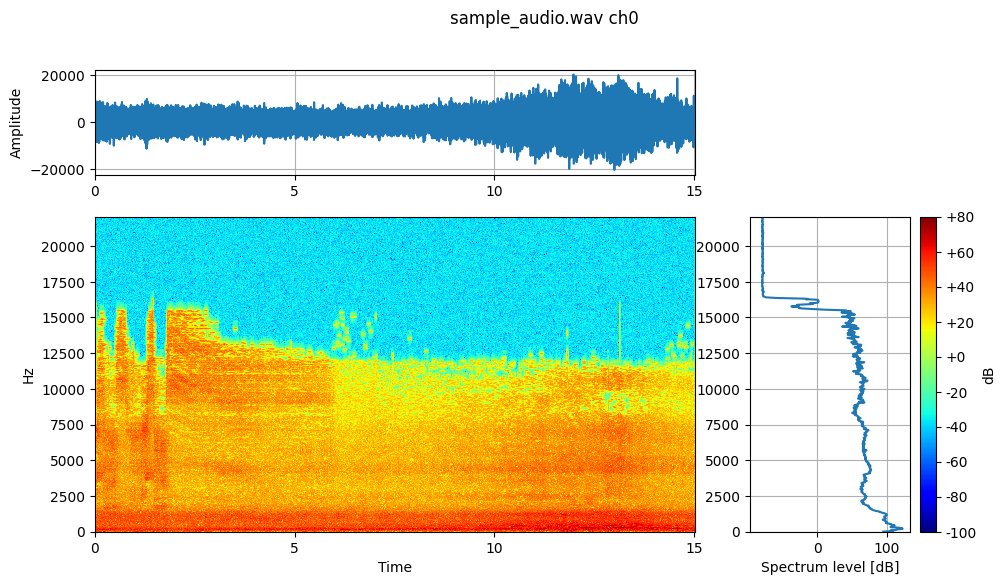

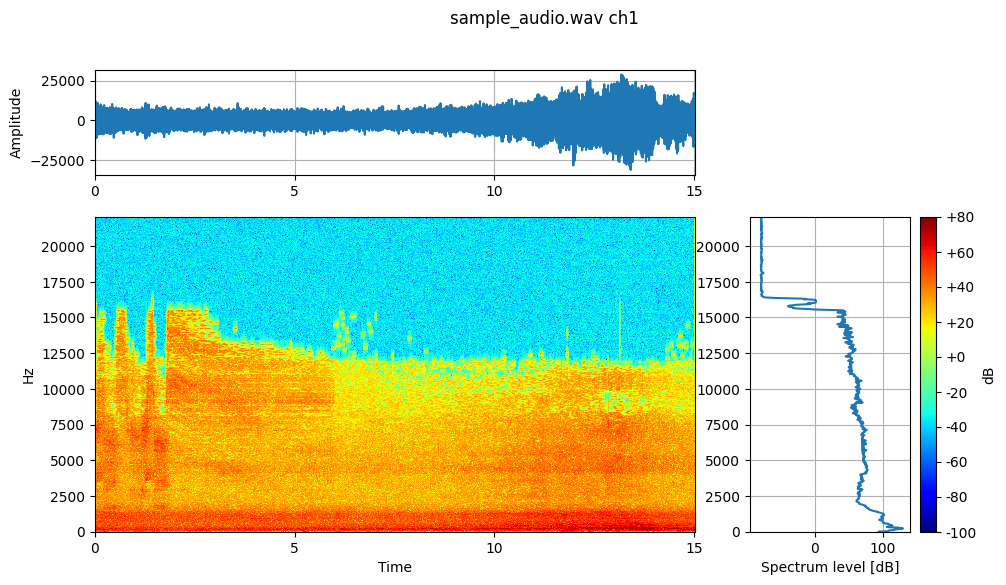

In [4]:
# 読み込んだ音声データを可視化
audio.describe()

## 📊 CSVファイルの読み込み

### なぜCSVが重要か

CSVは**センサーデータや計測データの標準フォーマット**です：
- **表形式**: 時間軸と複数のセンサー値を扱いやすい
- **汎用性**: Excel, MATLAB, Pythonなど多くのツールで扱える
- **柔軟性**: カスタムフォーマットに対応可能
- **テキストベース**: バージョン管理システムで扱いやすい

In [5]:
# サンプルCSVファイルを作成
csv_path = Path("sensor_data.csv")

# センサーデータを生成（加速度センサー風）
np.random.seed(42)  # 再現性のために
duration = 60
sampling_rate = 100  # 100Hz
n_samples = int(duration * sampling_rate)
time = np.linspace(0, duration, n_samples)

# 3軸加速度データ + 温度
accel_x = 0.8 * np.sin(2 * np.pi * 1.0 * time) + 0.1 * np.random.randn(n_samples)
accel_y = 1.2 * np.sin(2 * np.pi * 1.5 * time) + 0.1 * np.random.randn(n_samples)
accel_z = 0.5 * np.sin(2 * np.pi * 2.0 * time) + 0.1 * np.random.randn(n_samples)
temperature = 25.0 + 2.0 * np.sin(2 * np.pi * 0.1 * time) + 0.5 * np.random.randn(n_samples)

# CSVファイルに保存
import pandas as pd
df = pd.DataFrame({
    'time': time,
    'accel_x': accel_x,
    'accel_y': accel_y,
    'accel_z': accel_z,
    'temperature': temperature
})
df.to_csv(csv_path, index=False)
print(f"✅ サンプルCSVファイル作成: {csv_path}")
print(f"   行数: {len(df)}")
print(f"   列: {list(df.columns)}")

✅ サンプルCSVファイル作成: sensor_data.csv
   行数: 6000
   列: ['time', 'accel_x', 'accel_y', 'accel_z', 'temperature']


In [6]:
# CSVファイルを読み込み
sensor_data = wd.read_csv(
    csv_path,
    time_column='time',  # 時間軸の列名
    delimiter=','        # 区切り文字
)

print("📊 CSVファイル読み込み結果:")
print(f"  ファイル: {csv_path.name}")
print(f"  チャンネル数: {sensor_data.n_channels}")
print(f"  サンプリングレート: {sensor_data.sampling_rate:.1f} Hz")
print(f"  長さ: {sensor_data.duration:.1f} 秒")
print(f"  チャンネル名: {sensor_data.labels}")
print(f"  データ形状: {sensor_data.shape}")

📊 CSVファイル読み込み結果:
  ファイル: sensor_data.csv
  チャンネル数: 4
  サンプリングレート: 99.0 Hz
  長さ: 60.6 秒
  チャンネル名: ['accel_x', 'accel_y', 'accel_z', 'temperature']
  データ形状: (4, 6000)


/home/vscode/.venv/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


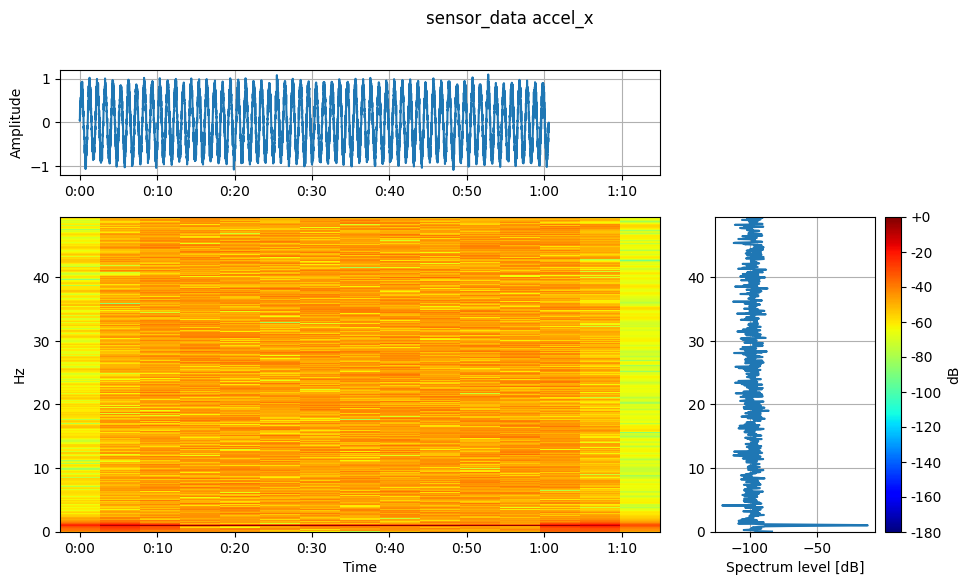

/home/vscode/.venv/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


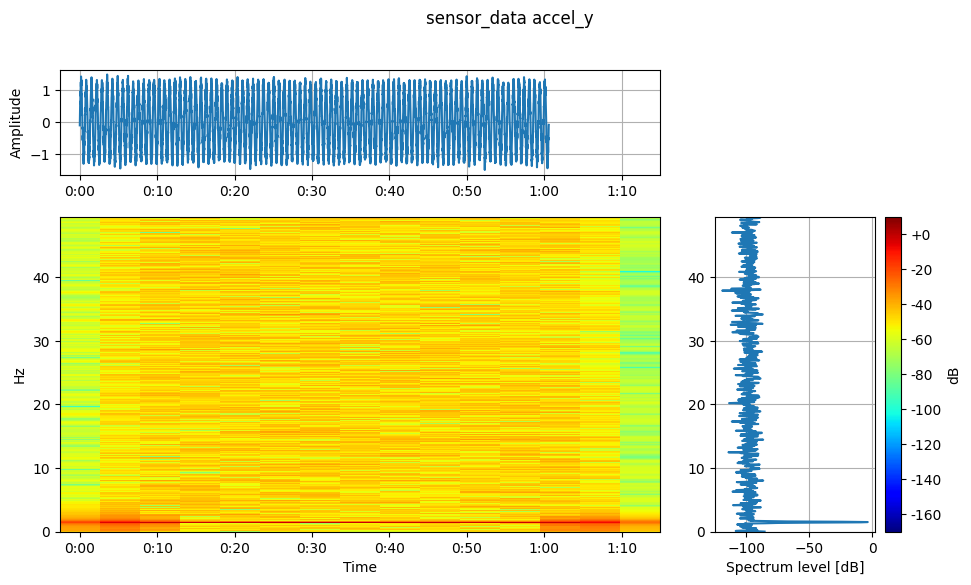

/home/vscode/.venv/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


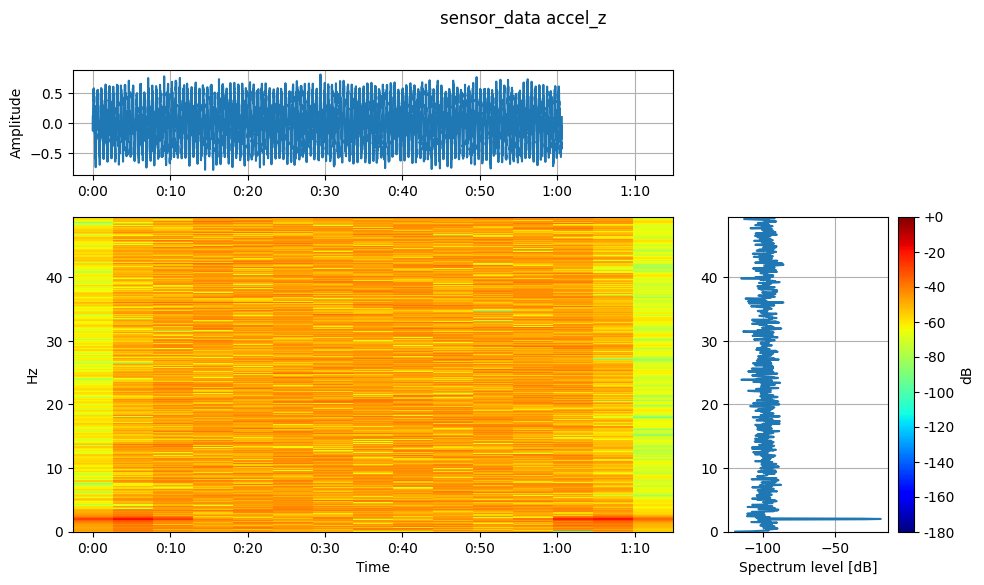

/home/vscode/.venv/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


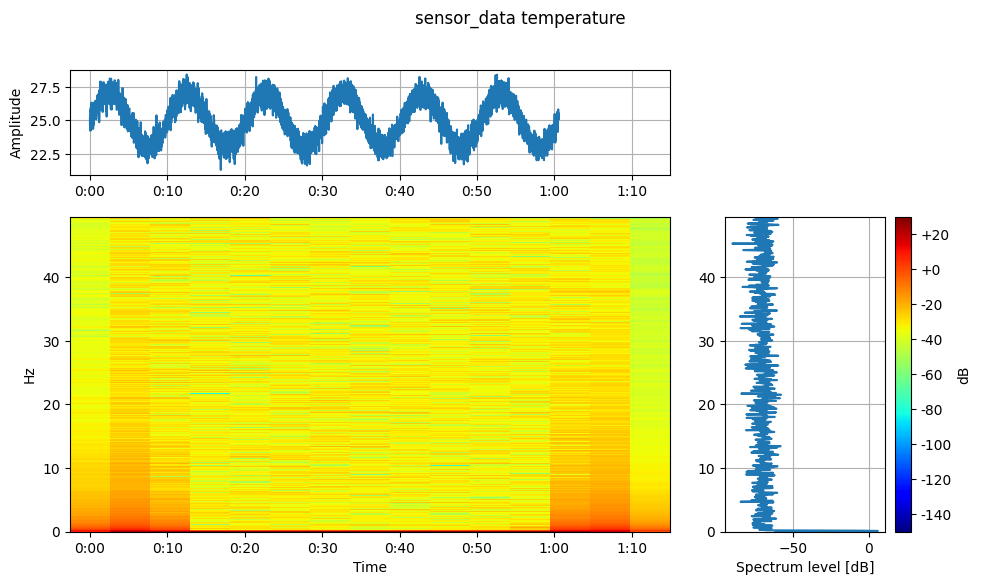

In [7]:
# センサーデータを可視化
sensor_data.describe()

## 🔢 NumPy配列からの作成

### なぜNumPy配列が重要か

NumPy配列は**計算結果やシミュレーションデータ**の標準形式です：
- **高速処理**: ベクトル化された演算
- **メモリ効率**: 連続したメモリ配置
- **相互運用**: 他の科学計算ライブラリとの互換性
- **柔軟性**: 任意の次元数とデータ型

In [8]:
# NumPy配列からChannelFrameを作成
np.random.seed(123)
sampling_rate = 1000  # 1kHz
duration = 2.0
n_samples = int(duration * sampling_rate)

# ステレオ音声風のデータを作成
time = np.linspace(0, duration, n_samples)
left_channel = np.sin(2 * np.pi * 440 * time) + 0.1 * np.random.randn(n_samples)
right_channel = np.sin(2 * np.pi * 440 * time + np.pi/4) + 0.1 * np.random.randn(n_samples)

# 2D配列にスタック
stereo_data = np.vstack([left_channel, right_channel])

# ChannelFrameを作成
stereo_audio = wd.from_numpy(
    data=stereo_data,
    sampling_rate=sampling_rate,
    ch_labels=['Left', 'Right']
)

print("🔢 NumPy配列からの作成結果:")
print(f"  データ形状: {stereo_data.shape} (channels, samples)")
print(f"  サンプリングレート: {stereo_audio.sampling_rate} Hz")
print(f"  チャンネル名: {stereo_audio.labels}")
print(f"  データ型: {stereo_audio.data.dtype}")

🔢 NumPy配列からの作成結果:
  データ形状: (2, 2000) (channels, samples)
  サンプリングレート: 1000 Hz
  チャンネル名: ['Left', 'Right']
  データ型: float64


/home/vscode/.venv/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


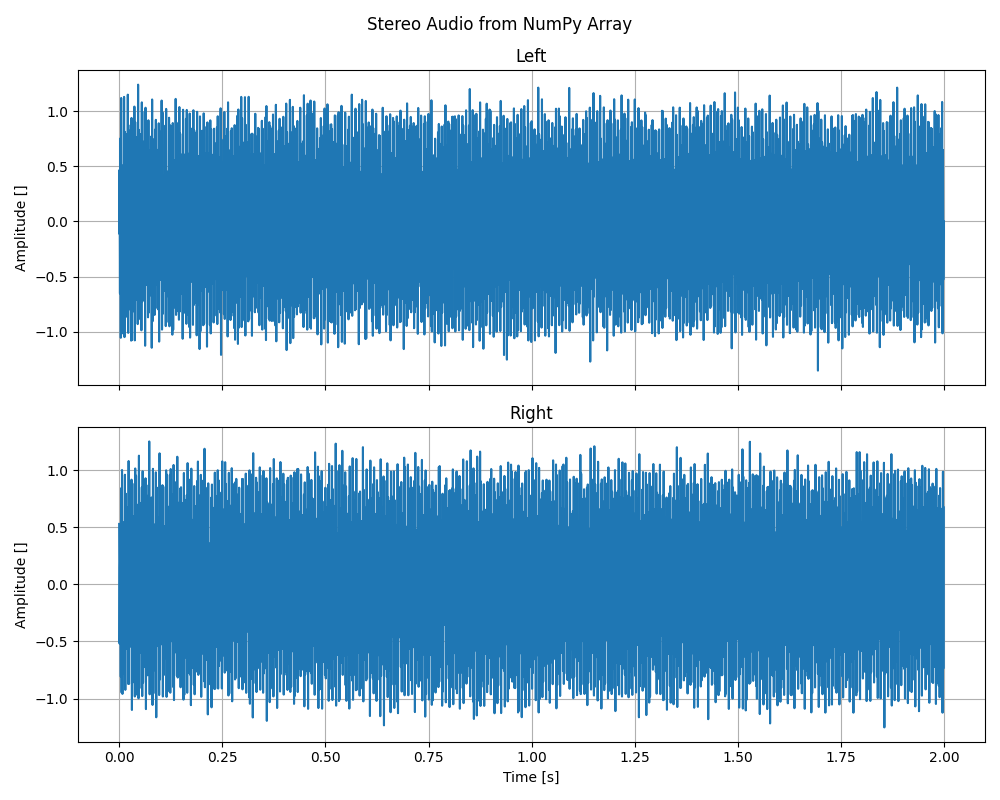

In [9]:
# NumPyデータも可視化
stereo_audio.plot(title="Stereo Audio from NumPy Array", overlay=False)

## 🏗️ ChannelFrameデータ構造の理解

### ChannelFrameの特徴

ChannelFrameはWandasの**基本的なデータ構造**です：

- **2Dデータ**: チャンネル × サンプルの行列
- **リッチメタデータ**: サンプリングレート、チャンネル名、単位、処理履歴
- **pandasライクAPI**: 直感的なアクセス方法
- **型安全性**: mypy対応の厳格な型付け
- **遅延評価**: Daskとの統合で大規模データ対応

In [10]:
# ChannelFrameの構造を詳しく調べる
print("🏗️ ChannelFrameの構造分析:")
print(f"  データ型: {type(sensor_data)}")
print(f"  データ形状: {sensor_data.shape}")
print(f"  データ型（NumPy）: {sensor_data.data.dtype}")
print(f"  メモリ使用量: {sensor_data.data.nbytes / 1024:.1f} KB")
print()

# メタデータ情報
print("📋 メタデータ:")
print(f"  サンプリングレート: {sensor_data.sampling_rate} Hz")
print(f"  チャンネル数: {sensor_data.n_channels}")
print(f"  サンプル数: {sensor_data.n_samples}")
print(f"  長さ: {sensor_data.duration:.2f} 秒")
print(f"  チャンネル名: {sensor_data.labels}")
print(f"  処理履歴: {[op.name for op in sensor_data.operation_history]}")

🏗️ ChannelFrameの構造分析:
  データ型: <class 'wandas.frames.channel.ChannelFrame'>
  データ形状: (4, 6000)
  データ型（NumPy）: float64
  メモリ使用量: 187.5 KB

📋 メタデータ:
  サンプリングレート: 99 Hz
  チャンネル数: 4
  サンプル数: 6000
  長さ: 60.61 秒
  チャンネル名: ['accel_x', 'accel_y', 'accel_z', 'temperature']
  処理履歴: []


## 🔍 チャンネルアクセスと操作

### pandasライクなアクセス方法

ChannelFrameは**pandasのDataFrameのようなアクセス**を提供します：
- **インデックスアクセス**: `cf[0]`, `cf['channel_name']`
- **スライシング**: `cf[0:2]`, `cf[['ch1', 'ch2']]`
- **ブールインデックス**: `cf[cf.rms > threshold]`

In [11]:
# 基本的なチャンネルアクセス
print("🔍 チャンネルアクセス方法:")

# インデックスでアクセス
first_channel = sensor_data[0]
print(f"  cf[0]: {first_channel.shape} - {first_channel.labels}")

# ラベルでアクセス
accel_x = sensor_data['accel_x']
print(f"  cf['accel_x']: {accel_x.shape} - {accel_x.labels}")

# 複数チャンネル選択
accel_channels = sensor_data[['accel_x', 'accel_y', 'accel_z']]
print(f"  cf[['accel_x', 'accel_y', 'accel_z']]: {accel_channels.shape} - {accel_channels.labels}")

# スライシング
first_two = sensor_data[0:2]
print(f"  cf[0:2]: {first_two.shape} - {first_two.labels}")

🔍 チャンネルアクセス方法:
  cf[0]: (6000,) - ['accel_x']
  cf['accel_x']: (6000,) - ['accel_x']
  cf[['accel_x', 'accel_y', 'accel_z']]: (3, 6000) - ['accel_x', 'accel_y', 'accel_z']
  cf[0:2]: (2, 6000) - ['accel_x', 'accel_y']


In [12]:
# 実践的なチャンネル操作
print("🎯 実践的なチャンネル操作:")

# RMS値でチャンネルをフィルタリング
rms_values = sensor_data.rms
print(f"  RMS値: {dict(zip(sensor_data.labels, rms_values))}")

# RMSが0.5以上のチャンネルのみ選択
active_channels = sensor_data[rms_values > 0.5]
print(f"  アクティブチャンネル: {active_channels.labels}")

# 特定の時間範囲を抽出
time_slice = sensor_data[:, 100:200]  # サンプル100-200
print(f"  時間スライス: {time_slice.shape} samples")

# チャンネル間の演算
magnitude = np.sqrt(sensor_data['accel_x']**2 + sensor_data['accel_y']**2 + sensor_data['accel_z']**2)
print(f"  ベクトルの大きさ: {magnitude.shape}")

🎯 実践的なチャンネル操作:
  RMS値: {'accel_x': np.float64(0.5760888015737184), 'accel_y': np.float64(0.8542083180601836), 'accel_z': np.float64(0.3687302384011476), 'temperature': np.float64(25.041388270418796)}
  アクティブチャンネル: ['accel_x', 'accel_y', 'temperature']
  時間スライス: (4, 100) samples
  ベクトルの大きさ: (1, 6000)


/home/vscode/.venv/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


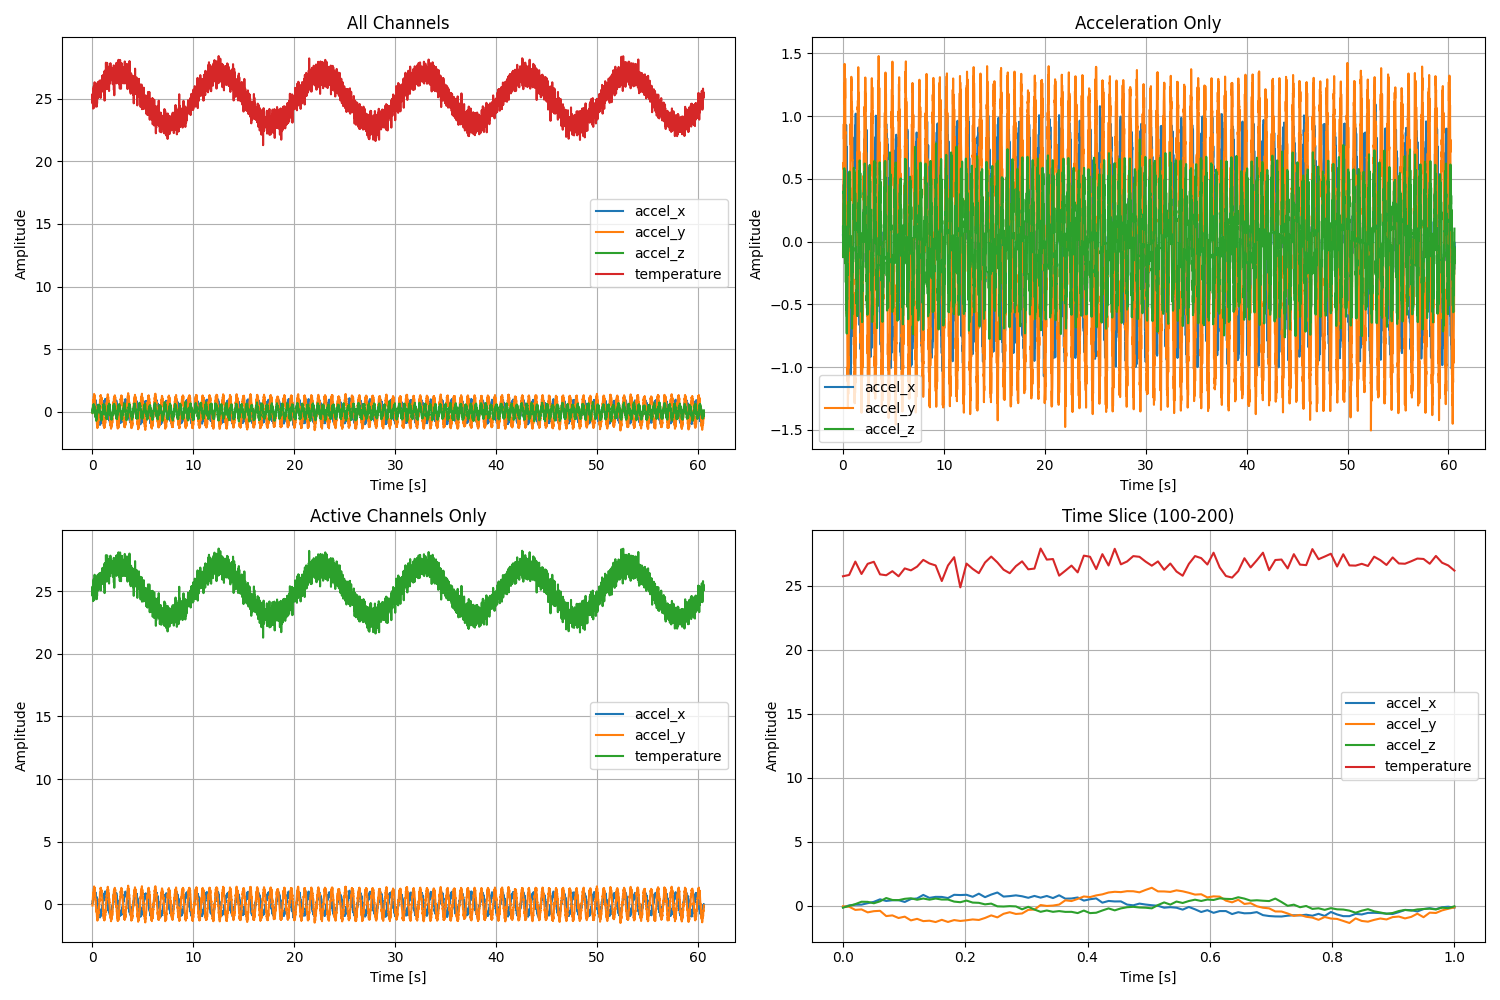

In [13]:
# チャンネル操作の可視化
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 元のデータ
sensor_data.plot(ax=axes[0,0], title='All Channels', overlay=True)

# 加速度チャンネルのみ
sensor_data[['accel_x', 'accel_y', 'accel_z']].plot(ax=axes[0,1], title='Acceleration Only', overlay=False)

# アクティブチャンネルのみ
active_channels.plot(ax=axes[1,0], title='Active Channels Only', overlay=True)

# 時間スライス
time_slice.plot(ax=axes[1,1], title='Time Slice (100-200)', overlay=True)

plt.tight_layout()
plt.show()

## 💾 データの保存

### さまざまなフォーマットでの保存

Wandasは**読み込み時と同じ柔軟性**でデータを保存できます：
- **WAV**: 音声データとして保存
- **WDF**: Wandas専用フォーマット（メタデータ完全保存）
- **NumPy**: 高速処理用
- **CSV**: 表計算ソフト用

In [14]:
# 処理したデータを保存
output_dir = Path("output")
output_dir.mkdir(exist_ok=True)

# WAV形式で保存
wav_output = output_dir / "processed_audio.wav"
audio.to_wav(wav_output)
print(f"✅ WAV保存: {wav_output}")

# WDF形式で保存（メタデータ完全保存）
wdf_output = output_dir / "sensor_data.wdf"
sensor_data.trim(start=0, end=1).save(wdf_output, overwrite=True)
print(f"✅ WDF保存: {wdf_output}")

# NumPy形式で保存
np_output = output_dir / "stereo_audio.npy"
np.save(np_output, stereo_audio.data)
print(f"✅ NumPy保存: {np_output}")

# CSV形式で保存
csv_output = output_dir / "processed_sensors.csv"
sensor_data.to_dataframe().to_csv(csv_output)
print(f"✅ CSV保存: {csv_output}")

✅ WAV保存: output/processed_audio.wav
✅ WDF保存: output/sensor_data.wdf
✅ NumPy保存: output/stereo_audio.npy
✅ CSV保存: output/processed_sensors.csv


In [15]:
# 保存したデータを読み込んで確認
print("🔄 保存データの読み込み確認:")

# WDFファイルを読み込み
loaded_wdf = wd.ChannelFrame.load(wdf_output)
print(f"  WDF読み込み: {loaded_wdf.shape} - メタデータ保持: {len(loaded_wdf.operation_history)} operations")

# NumPyファイルを読み込み
loaded_np = wd.from_numpy(
    data=np.load(np_output),
    sampling_rate=stereo_audio.sampling_rate,
    ch_labels=stereo_audio.labels
)
print(f"  NumPy読み込み: {loaded_np.shape} - サンプリングレート: {loaded_np.sampling_rate} Hz")

# CSVファイルを読み込み
loaded_csv = wd.read_csv(csv_output, time_column='time')
print(f"  CSV読み込み: {loaded_csv.shape} - チャンネル: {loaded_csv.labels}")

🔄 保存データの読み込み確認:
  WDF読み込み: (4, 99) - メタデータ保持: 1 operations
  NumPy読み込み: (2, 2000) - サンプリングレート: 1000 Hz
  CSV読み込み: (4, 6000) - チャンネル: ['accel_x', 'accel_y', 'accel_z', 'temperature']


## 🎯 実践的なワークフロー例

### センサーデータ分析の完全な例

現実的な信号処理ワークフローを体験しましょう。

🚀 完全な信号処理ワークフロー:
1. 📂 データ読み込み
   読み込み完了: (4, 6000)
2. 🔧 前処理
   処理完了: 3 operations
3. 📊 特徴抽出
   RMS: {'accel_x': np.float64(0.6158137551951001), 'accel_y': np.float64(0.5683034136980817), 'accel_z': np.float64(0.5838958238004108), 'temperature': np.float64(0.23951780353656835)}
4. 📈 可視化


/home/vscode/.venv/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


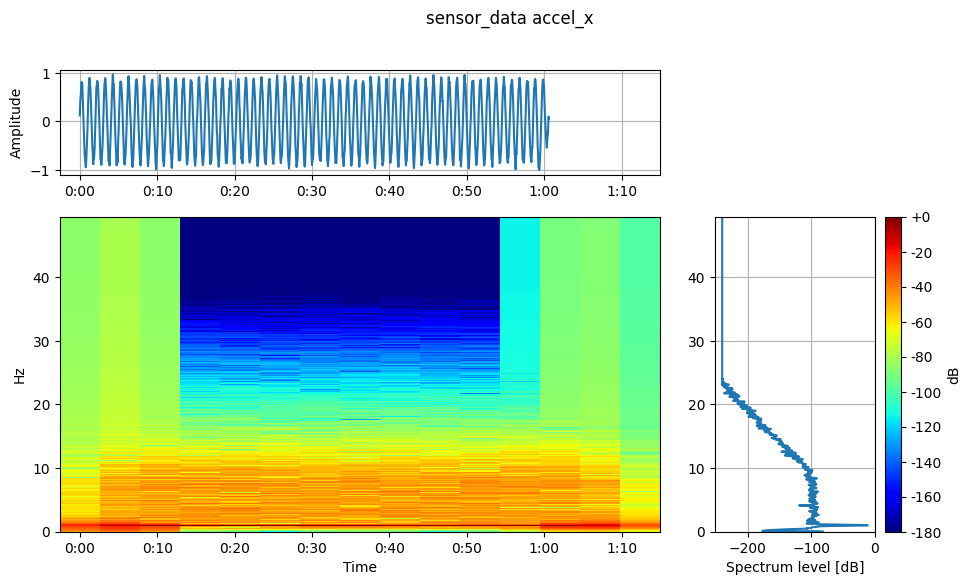

/home/vscode/.venv/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


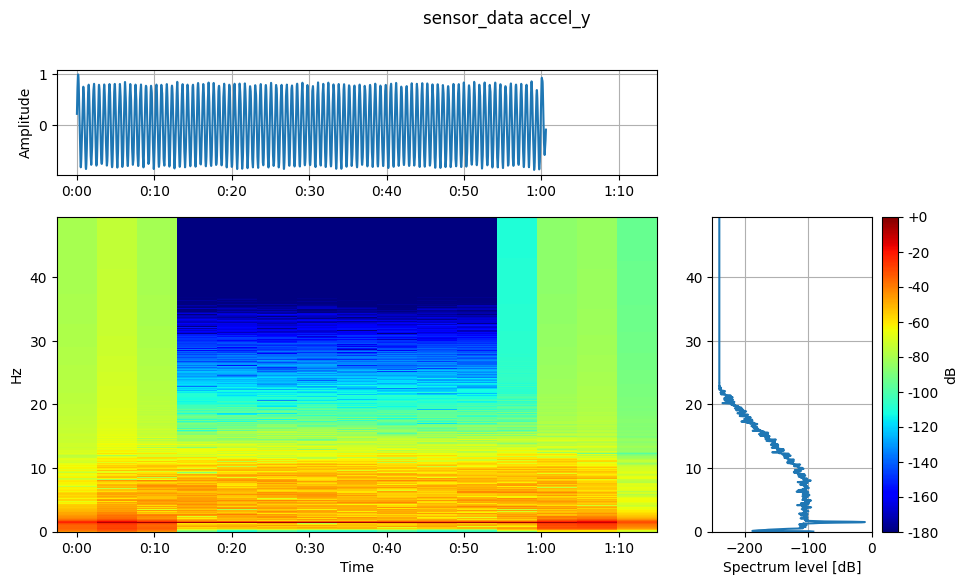

/home/vscode/.venv/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


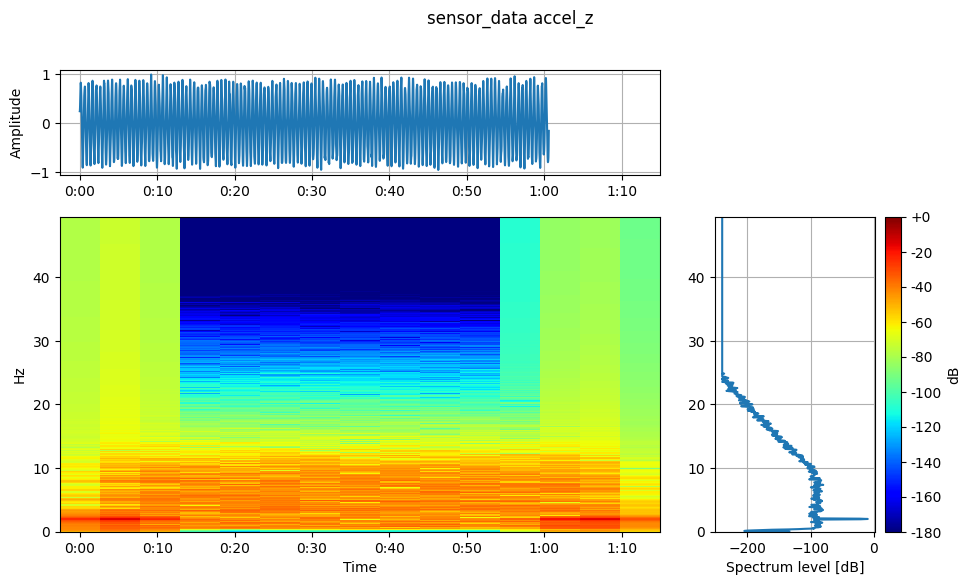

/home/vscode/.venv/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


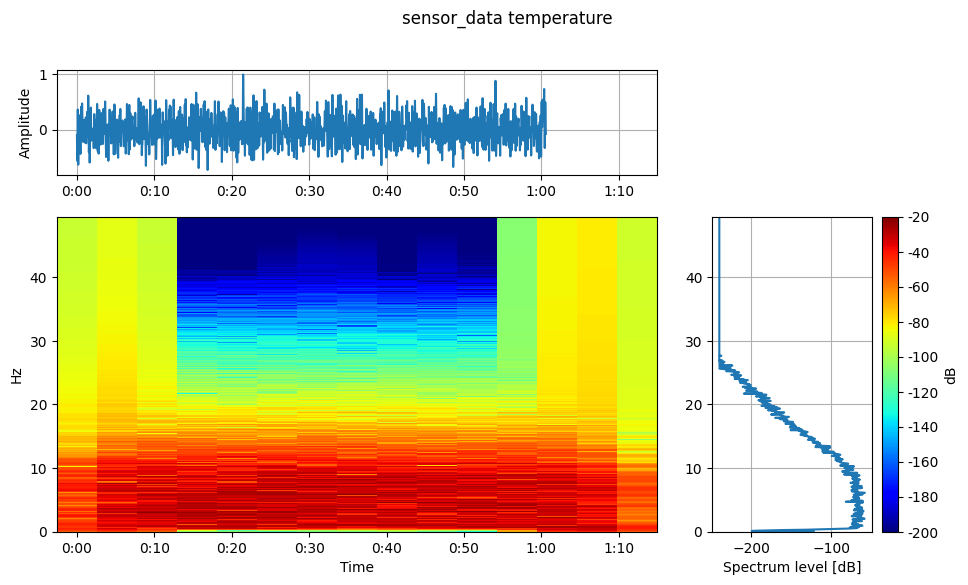

5. 💾 保存
   保存完了: output/analyzed_sensor_data.wdf

✅ ワークフロー完了！


In [16]:
# 完全なワークフロー: データ読み込み → 処理 → 保存
print("🚀 完全な信号処理ワークフロー:")

# 1. データ読み込み
print("1. 📂 データ読み込み")
data = wd.read_csv(csv_path, time_column='time')
print(f"   読み込み完了: {data.shape}")

# 2. 前処理
print("2. 🔧 前処理")
processed = (
    data
    .high_pass_filter(cutoff=0.5)  # 直流成分除去
    .low_pass_filter(cutoff=10)    # 高周波ノイズ除去
    .normalize()                   # 正規化
)
print(f"   処理完了: {len(processed.operation_history)} operations")

# 3. 特徴抽出
print("3. 📊 特徴抽出")
features = {
    'rms': processed.rms,
    'peak': processed.abs().data.max(),
    'crest_factor': processed.abs().data.max(-1) / processed.rms
}
print(f"   RMS: {dict(zip(processed.labels, features['rms']))}")

# 4. 可視化
print("4. 📈 可視化")
processed.describe()

# 5. 保存
print("5. 💾 保存")
final_output = output_dir / "analyzed_sensor_data.wdf"
processed.save(final_output, overwrite=True)
print(f"   保存完了: {final_output}")

print("\n✅ ワークフロー完了！")

## 🛠️ トラブルシューティング

### よくある問題と解決法

#### 1. ファイル読み込みエラー
- **ファイルが存在するか確認**: `Path(file).exists()`
- **フォーマットが正しいか確認**: `file.suffix`
- **エンコーディング問題**: CSVの場合 `encoding='utf-8'` を指定

#### 2. サンプリングレートの問題
- **明示的に指定**: `wd.read_wav(file, sampling_rate=44100)`
- **自動検出**: `wd.read_wav(file)` でファイルから取得

#### 3. メモリ不足
- **チャンク読み込み**: 大きなファイルを分割して読み込み
- **ダウンサンプリング**: `data.resample(target_sr=22050)`

#### 4. チャンネル名の不一致
- **明示的に指定**: `ch_labels=['ch1', 'ch2', 'ch3']`
- **自動生成**: 指定しない場合 `Channel 0`, `Channel 1`... となる

## 📚 次のステップ

データの読み込みと基本操作をマスターしました！

**次のノートブック**: [03_signal_processing_basics.ipynb](03_signal_processing_basics.ipynb)

ここでは、読み込んだデータを**フィルタリング**や**周波数分析**などの信号処理テクニックで加工する方法を紹介します。

### 🎯 これまでに学んだこと
- ✅ さまざまなファイル形式（WAV, CSV, NumPy）からのデータ読み込み
- ✅ ChannelFrameデータ構造の理解
- ✅ pandasライクなチャンネルアクセス方法
- ✅ メタデータの管理と処理履歴
- ✅ 複数フォーマットでのデータ保存
- ✅ 完全な信号処理ワークフローの実践

### 🚀 次の学習目標
- FFTによる周波数領域変換
- ローパス/ハイパス/バンドパスフィルタ
- スペクトル分析
- フィルタ設計の基礎

---

**データ操作の基礎を身につけました。次の信号処理の世界へ！** 🎵